# classifier

**import**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

**functions**

In [2]:
import tensorflow.keras.preprocessing.image as tfimage

def load_datasets(path):
  clean = []
  types = []
  label = []

  # loop over every folder
  i = -1
  k = 0
  for folder in os.listdir(path):
    i += 1
    label.append(folder)
    print(i, ": ", folder)
    for file in os.listdir(path + '/' + folder):
        # image = tfimage.load_img(path + '/' + folder + '/' + file, target_size=(256,256))
        # image = tfimage.img_to_array(image).astype('float32') / 255
        img = tfimage.load_img(path + '/' + folder + '/' + file)
        img = cv2.imread(os.path.join(path,folder,file),cv2.IMREAD_GRAYSCALE) # Convert to Image to Grayscale bc contour
        img=~img # Invert the bits of image 255 -> 0 / test the dataset
        if img is not None:
          ret,thresh=cv2.threshold(img,127,255,cv2.THRESH_BINARY) # THRESH_BINARY: Set bits > 127 to 1(white background) and <= 127 to 0(black) 
          ctrs, ret = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) # determine object boundary, remove background
          cnt=sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
          w=int(28)
          h=int(28)
          # maximum area of the rectangle
          maxi=0
          for c in cnt: # traverse in all the rectangles we have
            x,y,w,h=cv2.boundingRect(c)
            maxi=max(w*h,maxi)
            if maxi==w*h:
              x_max=x
              y_max=y
              w_max=w
              h_max=h
          im_crop= thresh[y_max:y_max+h_max+10, x_max:x_max+w_max+10] # add 10 extra margin to avoid error
          im_resize = cv2.resize(im_crop,(28,28))
          im_resize =  tfimage.img_to_array(im_resize).astype('float32') / 255
          #im_resize=np.reshape(im_resize,(784,1)) #resize to (28,28)
          clean.append(im_resize) # flat the matrix
          types.append(i)

  types = tf.one_hot(types, depth=i+1)
  types = np.array(types)
  clean = np.array(clean)

  print("image shape: ", clean.shape)
  print("label shape: ", types.shape)
  
  return types, clean, label

In [3]:
def preprocess(path):
  # load data
  types, clean, label = load_datasets(path)
  # permutation
  idx = np.random.permutation(np.arange(types.shape[0]))
  clean = clean[idx]
  types = types[idx]
  # split
  train_num = round(len(clean)*0.8)
  print("train num: ", train_num)
  print("test num: ", len(clean) - train_num)
  #80% of images to training set
  clean_train = clean[0:train_num]
  clean_test = clean[train_num:]
  types_train = types[0:train_num]
  types_test = types[train_num:]

  return clean_train, clean_test, types_train, types_test, label

In [4]:
from tensorflow.keras import layers, Model

def build_model(class_num):
  img_input = layers.Input(shape=(28, 28, 1))

  x = layers.Conv2D(30, 5, activation='relu')(img_input)
  x = layers.MaxPooling2D(2)(x)

  x = layers.Conv2D(15, 3, activation='relu')(x)
  x = layers.MaxPooling2D(2)(x)

  # x = layers.Conv2D(8, 1, activation='relu')(x)
  # x = layers.MaxPooling2D(2)(x)
  x = layers.Dropout(0.2)(x)

  x = layers.Flatten()(x)
  x = layers.Dense(128, activation='relu')(x)
  x = layers.Dense(50, activation='relu')(x)
  output = layers.Dense(class_num, activation='softmax')(x)

  model = Model(img_input, output)

  return model

# main

**create model**

In [7]:
# load data
path = 'C:\\Users\\USER\\Desktop\\Handwritten-Equation-Recognition---CNN-master\\dataset'
clean_train, clean_test, types_train, types_test, label = preprocess(path)

0 :  +
1 :  -
2 :  0
3 :  1
4 :  2
5 :  3
6 :  4
7 :  5
8 :  6
9 :  7
10 :  8
11 :  9
12 :  x
image shape:  (156617, 28, 28, 1)
label shape:  (156617, 13)
train num:  125294
test num:  31323


In [8]:
# build model
class_num = 13
classifier = build_model(class_num)
print(classifier.summary())

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 30)        780       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 30)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 15)        4065      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 15)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 15)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 375)              

In [9]:
# compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
classifier.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

**train model**

In [10]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights = True)

history = classifier.fit(
    x = clean_train, y = types_train,
    batch_size = 10,
    epochs = 10,
    callbacks = [callback],
    validation_data = (clean_test, types_test))

Epoch 1/10
12530/12530 [==============================] - 150s 12ms/step - loss: 0.1547 - accuracy: 0.9563 - val_loss: 0.0547 - val_accuracy: 0.9862
Epoch 2/10
12530/12530 [==============================] - 152s 12ms/step - loss: 0.0560 - accuracy: 0.9844 - val_loss: 0.0330 - val_accuracy: 0.9924
Epoch 3/10
12530/12530 [==============================] - 170s 14ms/step - loss: 0.0391 - accuracy: 0.9895 - val_loss: 0.0353 - val_accuracy: 0.9920
Epoch 4/10
12530/12530 [==============================] - 153s 12ms/step - loss: 0.0318 - accuracy: 0.9914 - val_loss: 0.0204 - val_accuracy: 0.9956
Epoch 5/10
12530/12530 [==============================] - 154s 12ms/step - loss: 0.0257 - accuracy: 0.9931 - val_loss: 0.0221 - val_accuracy: 0.9957
Epoch 6/10
12530/12530 [==============================] - 152s 12ms/step - loss: 0.0250 - accuracy: 0.9934 - val_loss: 0.0323 - val_accuracy: 0.9922
Epoch 7/10
12530/12530 [==============================] - 151s 12ms/step - loss: 0.0215 - accuracy: 0.9942

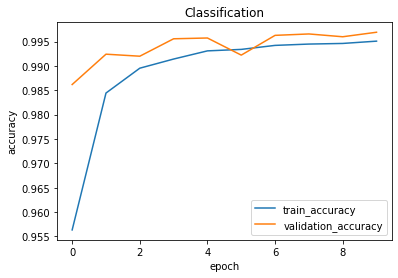

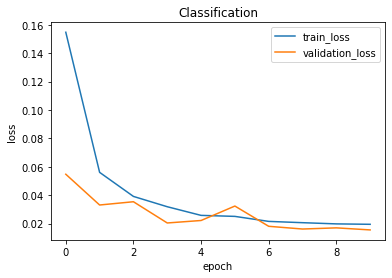

In [11]:
def plot_accuracy(history, title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.savefig("best_1")
    plt.show()

def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.savefig("best_2")
    plt.show()

plot_accuracy(history,'Classification')
plot_loss(history,'Classification')


**save trained model**

In [42]:
classifier.save("little_helper.h5")